## ME6 Linear Regression with Gradient Descent

Write your name and your collaborators if any. 

- Alex Larsen
- Mia Rodgers

### Set up 

In [46]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Part 0

- Read and run each cell of the given examples: (1) synthetic dataset (2) crime dataset

- Understand the results. In particular, see how feature normalization affects on ridges regression and how the model performance changes when varying alpha parameter values are used in both ridge regression and Lasso regression. 

### Linear models for regression

- Visit sklearn web site:
   - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


- Please also check model evaluation metrics for regression:

    - https://scikit-learn.org/stable/modules/model_evaluation.html

    - ME5 Simple Linear Regression shows evaluation metrics for regression in detail. 

### Preparing X and Y using pandas
- We already did this process above
- scikit-learn expects X (feature matrix) and Y (response vector) to be NumPy arrays.
- However, pandas is built on top of NumPy.
- Thus, X can be a pandas DataFrame and y can be a pandas Series!

### Dataset 1: Synthetic random data points

- One single attribute in X

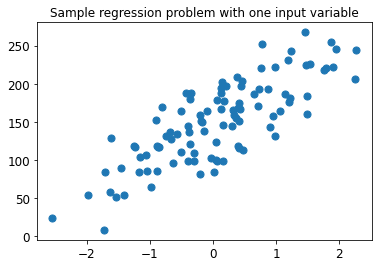

In [2]:
from sklearn.datasets import make_classification, make_blobs
from matplotlib.colors import ListedColormap

# synthetic dataset for simple regression
from sklearn.datasets import make_regression

plt.figure()
plt.title('Sample regression problem with one input variable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                             n_informative=1, bias = 150.0,
                             noise = 30, random_state=0)

plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

#### Linear regression on synthetic dataset


In [3]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1, random_state=0)

linreg = LinearRegression().fit(X_train, y_train)

#### Linear regression model coefficient and intercept values \& performance metrics

In [4]:
from sklearn import metrics

print('linear model intercept (b): {:.3f}'.format(linreg.intercept_))
print('linear model coeff (w): {}'.format(linreg.coef_))

# train data R2
print('R-squared score (training): {:.3f}'.format(linreg.score(X_train, y_train)))
# test data R2
print('R-squared score (test): {:.3f}'.format(linreg.score(X_test, y_test)))

# make predictions on the testing set and print RMSE
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

linear model intercept (b): 148.446
linear model coeff (w): [45.70870465]
R-squared score (training): 0.679
R-squared score (test): 0.492
RMSE: 33.203


#### Linear regression cost optimization

First, we add 1 for x0 value to each data tuple

In [5]:
X_b = np.c_[np.ones((100, 1)), X_R1]  # add x0 = 1 to each data tuple
y_b = y_R1.reshape(100, 1)

print(X_b.shape, '\n', y_b.shape)

(100, 2) 
 (100, 1)


#### Obtain the exact theta vector using close form

<img src="images/cf.png" style="width: 200px;">

In [6]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_R1)
theta_best

array([147.55745452,  43.08728116])

#### Obtain theta using Gradient Descent

In [7]:
# learning rate
alpha = 0.01

# number of iterations
n_iteration = 100

# the number of data points
n = 100

# random initialization to theta. 
# Return samples (2 values for theta0 for x0 and theta1 for x1) 
# from the “standard normal” distribution.
theta = np.random.randn(2, 1)

print('initial theta: \n', theta, theta.shape)

initial theta: 
 [[ 0.49671415]
 [-0.1382643 ]] (2, 1)


In [8]:
# the process of gradient descent
for iteration in range(n_iteration):
    gradient = (1/n) * X_b.T.dot(X_b.dot(theta) - y_b)
    theta = theta - alpha*gradient
    
print('best theta: \n', theta)

# we will need to tune with learning rate alpha and # of iterations
# to find out the optimal theta value

best theta: 
 [[94.57899586]
 [30.76669701]]


#### plot the linear model with scatter plot

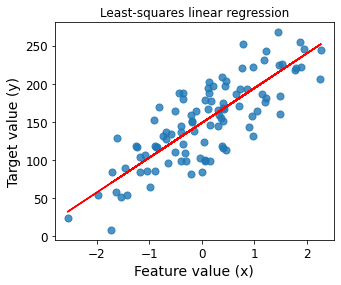

In [9]:
plt.figure(figsize=(5,4))
plt.scatter(X_R1, y_R1, marker= 'o', s=50, alpha=0.8)
plt.plot(X_R1, linreg.coef_ * X_R1 + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Feature value (x)')
plt.ylabel('Target value (y)')
plt.show()

### Dataset 2: crime dataset

In [10]:
def load_crime_dataset():
    # Communities and Crime dataset for regression
    # https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized

    # na_values='?'
    crime = pd.read_csv('./data/CommViolPredUnnormalizedData.csv', na_values='?')
    # remove features with poor coverage or lower relevance, and keep ViolentCrimesPerPop target column
    columns_to_keep = [5, 6] + list(range(11,26)) + list(range(32, 103)) + [145]  
    
    crime = crime.iloc[:, columns_to_keep]
    crime = crime.dropna()
    
    X_crime = crime.iloc[:, 0:88]
    y_crime = crime['ViolentCrimesPerPop']

    return (X_crime, y_crime)

In [11]:
# Communities and Crime dataset
(X_crime, y_crime) = load_crime_dataset()

#print(X_crime.head())
#print(y_crime.head())

In [12]:
print(X_crime.shape, '\n', y_crime.shape)

(1994, 88) 
 (1994,)


In [13]:
X = np.c_[np.ones((1994, 1)), X_crime]
X.shape
# now there are 89 attributes including x0 and 88 data attributes

(1994, 89)

In [14]:
y = y_crime.values.reshape(1994, 1)

print(y.shape,'\n', y)

(1994, 1) 
 [[ 41.02]
 [127.56]
 [218.59]
 ...
 [353.83]
 [691.17]
 [918.89]]


In [15]:
eta = 0.05  # learning rate
n_iterations = 10 # number of total iterations
n = 1994 # the number of data

theta = np.random.randn(89, 1)  # random initialization

# print(theta.shape, '\n', theta)

In [16]:
for iteration in range(n_iterations):
    gradient = (1/n) * X.T.dot(X.dot(theta) - y)
    theta = theta - eta * gradient
    
# print(theta)

In [17]:
X_new = X_crime.iloc[:1, 0:88]
X_new_b = np.c_[np.ones((1, 1)), X_new] 
y_new = y_crime[0]

y_predict = X_new_b.dot(theta)

print(y_new, '\n', y_predict)

41.02 
 [[1.99497415e+102]]


#### Linear regression on crime dataset (without regularization)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime, random_state=0)
linreg = LinearRegression().fit(X_train, y_train)

print('Crime dataset')
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

print('linear model intercept: {}'.format(linreg.intercept_))
print('linear model coeff:\n{}'.format(linreg.coef_))

print('Number of non-zero features: {}'.format(np.sum(linreg.coef_ != 0)))

Crime dataset
R-squared score (training): 0.673
R-squared score (test): 0.496
RMSE: 454.949
linear model intercept: -1728.1306726014718
linear model coeff:
[ 1.61892346e-03 -9.43009110e+01  1.36067510e+01 -3.13380670e+01
 -8.15482721e-02 -1.69455128e+01 -2.42730375e-03  1.53013232e+00
 -1.39193248e-02 -7.72112833e+00  2.28112354e+01 -5.65708295e+00
  9.34751364e+00  2.06969566e-01 -7.43413626e+00  9.65856476e-03
  4.38030290e-03  4.79754625e-03 -4.46469212e+00 -1.60907140e+01
  8.82778012e+00 -5.06734503e-01 -1.42198055e+00  8.17551991e+00
 -3.87048268e+00 -3.54209213e+00  4.48758304e+00  9.30645715e+00
  1.73644996e+02  1.18220766e+01  1.51120836e+02 -3.29613007e+02
 -1.35343395e+02  6.95380108e-01 -2.38369008e+01  2.77038981e+00
  3.82248925e-01  4.38813358e+00 -1.06410851e+01 -4.92294176e-03
  4.14031827e+01 -1.16206866e-03  1.18568968e+00  1.75418465e+00
 -3.68283678e+00  1.59679443e+00 -8.42180230e+00 -3.79703897e+01
  4.74076990e+01 -2.50768374e+01 -2.88246410e-01 -3.65633234e+01

#### Ridge regression (regularized regression)

In [19]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime, random_state=0)

linridge = Ridge(alpha=20.0).fit(X_train, y_train)

print('Crime dataset')

print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test, y_test)))

# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

print('ridge regression linear model intercept: {}'.format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'.format(linridge.coef_))

print('Number of non-zero features: {}'.format(np.sum(linridge.coef_ != 0)))

Crime dataset
R-squared score (training): 0.671
R-squared score (test): 0.494
RMSE: 454.949
ridge regression linear model intercept: -3352.423035846117
ridge regression linear model coeff:
[ 1.95091438e-03  2.19322667e+01  9.56286607e+00 -3.59178973e+01
  6.36465325e+00 -1.96885471e+01 -2.80715856e-03  1.66254486e+00
 -6.61426604e-03 -6.95450680e+00  1.71944731e+01 -5.62819154e+00
  8.83525114e+00  6.79085746e-01 -7.33614221e+00  6.70389803e-03
  9.78505502e-04  5.01202169e-03 -4.89870524e+00 -1.79270062e+01
  9.17572382e+00 -1.24454193e+00  1.21845360e+00  1.03233089e+01
 -3.78037278e+00 -3.73428973e+00  4.74595305e+00  8.42696855e+00
  3.09250005e+01  1.18644167e+01 -2.05183675e+00 -3.82210450e+01
  1.85081589e+01  1.52510829e+00 -2.20086608e+01  2.46283912e+00
  3.29328703e-01  4.02228467e+00 -1.12903533e+01 -4.69567413e-03
  4.27046505e+01 -1.22507167e-03  1.40795790e+00  9.35041855e-01
 -3.00464253e+00  1.12390514e+00 -1.82487653e+01 -1.54653407e+01
  2.41917002e+01 -1.32497562e+0

#### Ridge regression with feature normalization

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('Crime dataset')
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))

# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

print('ridge regression linear model intercept: {}'.format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'.format(linridge.coef_))

print('Number of non-zero features: {}'.format(np.sum(linridge.coef_ != 0)))

Crime dataset
R-squared score (training): 0.615
R-squared score (test): 0.599
RMSE: 454.949
ridge regression linear model intercept: 933.3906385044154
ridge regression linear model coeff:
[  88.68827454   16.48947987  -50.30285445  -82.90507574  -65.89507244
   -2.27674244   87.74108514  150.94862182   18.8802613   -31.05554992
  -43.13536109 -189.44266328   -4.52658099  107.97866804  -76.53358414
    2.86032762   34.95230077   90.13523036   52.46428263  -62.10898424
  115.01780357    2.66942023    6.94331369   -5.66646499 -101.55269144
  -36.9087526    -8.7053343    29.11999068  171.25963057   99.36919476
   75.06611841  123.63522539   95.24316483 -330.61044265 -442.30179004
 -284.49744001 -258.37150609   17.66431072 -101.70717151  110.64762887
  523.13611718   24.8208959     4.86533322  -30.46775619   -3.51753937
   50.57947231   10.84840601   18.27680946   44.11189865   58.33588176
   67.08698975  -57.93524659  116.1446052    53.81163718   49.01607711
   -7.62262031   55.14288543  -

#### Ridge regression with regularization parameter: alpha

In [21]:
print('Ridge regression: effect of alpha regularization parameter\n')
for this_alpha in [0, 1, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

Ridge regression: effect of alpha regularization parameter

Alpha = 0.00
num abs(coeff) > 1.0: 88, r-squared training: 0.67, r-squared test: 0.50

Alpha = 1.00
num abs(coeff) > 1.0: 87, r-squared training: 0.66, r-squared test: 0.56

Alpha = 10.00
num abs(coeff) > 1.0: 87, r-squared training: 0.63, r-squared test: 0.59

Alpha = 20.00
num abs(coeff) > 1.0: 88, r-squared training: 0.61, r-squared test: 0.60

Alpha = 50.00
num abs(coeff) > 1.0: 86, r-squared training: 0.58, r-squared test: 0.58

Alpha = 100.00
num abs(coeff) > 1.0: 87, r-squared training: 0.55, r-squared test: 0.55

Alpha = 1000.00
num abs(coeff) > 1.0: 84, r-squared training: 0.31, r-squared test: 0.30



/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.48872e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


#### Lasso regression

In [22]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train_scaled, y_train)

print('Crime dataset')

print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))

# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    
print('lasso regression linear model intercept: {}'.format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'.format(linlasso.coef_))

print('Non-zero features: {}'.format(np.sum(linlasso.coef_ != 0)))
 
print('Features with non-zero weight (sorted by absolute magnitude):')
for e in sorted (list(zip(list(X_crime), linlasso.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

Crime dataset
R-squared score (training): 0.631
R-squared score (test): 0.624

RMSE: 454.949
lasso regression linear model intercept: 1186.612061998579
lasso regression linear model coeff:
[    0.             0.            -0.          -168.18346054
    -0.            -0.             0.           119.6938194
     0.            -0.             0.          -169.67564456
    -0.             0.            -0.             0.
     0.             0.            -0.            -0.
     0.            -0.             0.             0.
   -57.52991966    -0.            -0.             0.
   259.32889226    -0.             0.             0.
     0.            -0.         -1188.7396867     -0.
    -0.            -0.          -231.42347299     0.
  1488.36512229     0.            -0.            -0.
    -0.             0.             0.             0.
     0.             0.            -0.             0.
    20.14419415     0.             0.             0.
     0.             0.           339.04468804 

#### Lasso regression with regularization parameter: alpha

In [23]:
print('Lasso regression: effect of alpha regularization\n\
parameter on number of features kept in final model\n')

for alpha in [0.5, 1, 2, 3, 5, 10, 20, 50]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)
    
    print('Alpha = {:.2f}\nFeatures kept: {}, r-squared training: {:.2f}, \
r-squared test: {:.2f}\n'
         .format(alpha, np.sum(linlasso.coef_ != 0), r2_train, r2_test))

Lasso regression: effect of alpha regularization
parameter on number of features kept in final model

Alpha = 0.50
Features kept: 35, r-squared training: 0.65, r-squared test: 0.58

Alpha = 1.00
Features kept: 25, r-squared training: 0.64, r-squared test: 0.60

Alpha = 2.00
Features kept: 20, r-squared training: 0.63, r-squared test: 0.62

Alpha = 3.00
Features kept: 17, r-squared training: 0.62, r-squared test: 0.63

Alpha = 5.00
Features kept: 12, r-squared training: 0.60, r-squared test: 0.61

Alpha = 10.00
Features kept: 6, r-squared training: 0.57, r-squared test: 0.58

Alpha = 20.00
Features kept: 2, r-squared training: 0.51, r-squared test: 0.50

Alpha = 50.00
Features kept: 1, r-squared training: 0.31, r-squared test: 0.30



## Part 1: Linear Regression Modeling on Breast Cancer dataset

a. Obtain the exact theta vector using closed form

b. Obtain the optimal theta vector using Gradient Descent

c. Apply the following regression model on breast cancer dataset

    (1) Linear regression without regularization

    (2) Ridge regression 

    (3) Ridge regression with feature normalization

    (4) Ridge regression with regularization parameter: alpha

    (5) Lasso regression

    (6) Lasso regression with regularization parameter: alpha

#### Dataloading: Breast cancer dataset

In [24]:
from sklearn.datasets import load_breast_cancer

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

print(cancer.feature_names)
y_cancer

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [25]:
from sklearn.metrics import mean_squared_error

def plot_learning_curves(model, X, y, title = None):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, random_state=0)
    train_errors, val_errors = [], []

    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(np.sqrt(train_errors), 'r--.', linewidth=0.5, label="train", markersize = 3)
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14)  # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown



In [26]:
X_cancer.shape

(569, 30)

In [27]:
X_b = np.c_[np.ones((569, 1)), X_cancer]

#### part a: closed form

In [28]:
# the Normal equation
# calculate best theta using linalg functions and dot product

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_cancer)

# print the value
print(theta_best)


[ 3.02181174e+00  2.17772056e-01 -4.54546867e-03 -2.37398610e-02
 -3.17834750e-04 -8.46891370e-02  4.22203525e+00 -1.39799728e+00
 -2.14183303e+00 -1.02709200e-01 -3.32616097e-02 -4.34955932e-01
  6.75847233e-03  2.25202577e-02  9.23217886e-04 -1.58543207e+01
 -6.49034090e-02  3.56546799e+00 -1.05679513e+01 -1.69734069e+00
  7.14644016e+00 -1.95183121e-01 -7.15937520e-03  2.43505057e-03
  1.01122332e-03 -5.42856861e-01 -6.71582941e-02 -3.81191215e-01
 -4.64309895e-01 -5.56787546e-01 -4.30348309e+00]


#### part b: gradient descent

In [29]:
# learning rate
alpha = 0.01

# number of iterations
n_iter = 72

# the number of data points
n = 569

# random initialization to theta.
# Return samples (2 values for theta0 and theta1) from the “standard normal” distribution.
theta = np.random.randn(31, 1)
print('initial theta: \n', theta)

print(theta.shape)
print(X_b.shape)

# the process of gradient descent
for iteration in range(n_iter):
    gradients = (1 / n) * X_b.T.dot(X_b.dot(theta) - y_cancer)
    theta = theta - alpha * gradients
print(theta.shape)
print('best theta: \n', theta)


initial theta: 
 [[ 0.96864499]
 [-1.34938997]
 [-1.01907279]
 [ 0.12701224]
 [-1.24944372]
 [ 1.94511561]
 [-0.15333646]
 [-0.90698723]
 [-0.81735416]
 [-0.48312268]
 [-0.56982835]
 [-2.09159967]
 [ 1.26374053]
 [-0.01548334]
 [-0.02737645]
 [ 0.81787351]
 [-1.05460447]
 [-0.75832712]
 [ 0.45741565]
 [-0.06437805]
 [ 0.34490234]
 [-0.08008734]
 [-0.24138013]
 [ 1.43351549]
 [ 1.06579371]
 [-2.49875914]
 [ 1.48032856]
 [ 2.15872852]
 [ 1.23177838]
 [-0.21432448]
 [-0.68919421]]
(31, 1)
(569, 31)
(31, 569)
best theta: 
 [[1.46816513e+300 1.46816513e+300 1.46816513e+300 ... 1.46816513e+300
  1.46816513e+300 1.46419168e+300]
 [2.37236165e+301 2.37236165e+301 2.37236165e+301 ... 2.37236165e+301
  2.37236165e+301 2.36594108e+301]
 [2.96044902e+301 2.96044902e+301 2.96044902e+301 ... 2.96044902e+301
  2.96044902e+301 2.95243685e+301]
 ...
 [2.11355906e+299 2.11355906e+299 2.11355906e+299 ... 2.11355906e+299
  2.11355906e+299 2.10783891e+299]
 [4.36259447e+299 4.36259447e+299 4.36259447e+299 

#### part c: models

##### (1) Linear regression without regularization

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state=0)
linreg = LinearRegression().fit(X_train, y_train)

print('Cancer dataset')
print('R-squared score (training): {:.3f}'.format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'.format(linreg.score(X_test, y_test)))

# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

print('linear model intercept: {}'.format(linreg.intercept_))
print('linear model coeff:\n{}'.format(linreg.coef_))

print('Number of non-zero features: {}'.format(np.sum(linreg.coef_ != 0)))

Cancer dataset
R-squared score (training): 0.782
R-squared score (test): 0.729
RMSE: 0.251
linear model intercept: 3.264323682949673
linear model coeff:
[ 1.95664033e-01 -1.24998359e-02 -1.83925145e-02 -3.08554299e-04
 -6.58769659e-01  4.67316114e+00 -1.41047944e+00 -1.79519061e+00
 -1.02466251e+00 -8.16682870e-01 -6.95506836e-01 -2.65194673e-02
  6.52894932e-02  3.22253562e-04 -1.16323309e+01 -4.43943865e-02
  3.04134165e+00 -8.31729413e+00 -2.44644000e+00  1.96844051e+01
 -1.78964757e-01 -2.00410588e-04 -4.02896117e-03  1.17548563e-03
 -4.04988322e-01 -1.15267671e-01 -4.11583121e-01 -9.11239745e-01
 -1.12925131e-01 -5.02459596e+00]
Number of non-zero features: 30


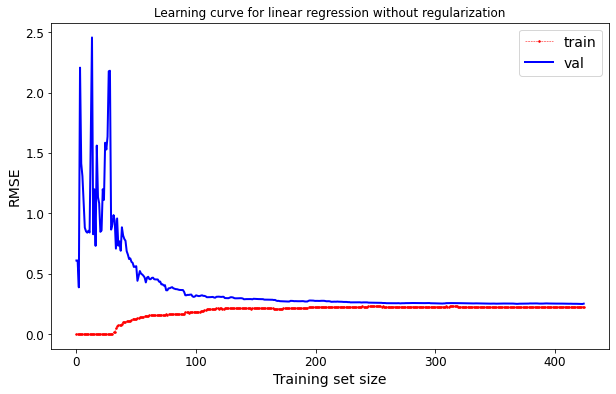

In [31]:
plot_learning_curves(linreg, X_cancer, y_cancer,
                     title='Learning curve for linear regression without regularization')


##### (2) Ridge regression 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cancer, y_cancer, random_state=0)

linridge = Ridge(alpha=20.0).fit(X_train, y_train)

print('Cancer dataset')

print('R-squared score (training): {:.3f}'
      .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
      .format(linridge.score(X_test, y_test)))

# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(
    np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

print('ridge regression linear model intercept: {}'.format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'.format(linridge.coef_))

print('Number of non-zero features: {}'.format(np.sum(linridge.coef_ != 0)))

Cancer dataset
R-squared score (training): 0.718
R-squared score (test): 0.701
RMSE: 0.251
ridge regression linear model intercept: 2.8876581523658107
ridge regression linear model coeff:
[ 8.95459514e-02  4.96576604e-03 -6.53071472e-03 -9.38715208e-06
 -1.70744323e-02 -2.48627421e-02 -4.93503540e-02 -2.77020642e-02
 -3.06915402e-02 -4.70309146e-03 -4.64609813e-02 -1.10244435e-02
 -1.66584359e-02 -3.44749865e-04 -2.54152959e-03  2.62285611e-04
 -1.16547194e-03 -2.54907417e-03 -5.31339660e-03 -7.79367812e-05
 -1.60523115e-01 -1.55701325e-02 -6.49252297e-03  1.01356127e-03
 -3.15652552e-02 -8.47221763e-02 -1.40803334e-01 -5.21846681e-02
 -6.76483639e-02 -1.53442711e-02]
Number of non-zero features: 30


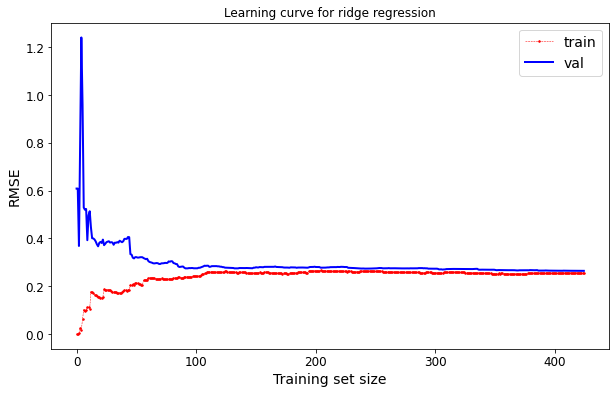

In [33]:
plot_learning_curves(linridge, X_cancer, y_cancer,
                     title='Learning curve for ridge regression')


##### (3) Ridge regression with feature normalization

In [34]:
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X_cancer, y_cancer, random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge_norm = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('Cancer dataset')
print('R-squared score (training): {:.3f}'
      .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
      .format(linridge.score(X_test_scaled, y_test)))

# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(
    np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

print('ridge regression linear model intercept: {}'.format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'.format(linridge.coef_))

print('Number of non-zero features: {}'.format(np.sum(linridge.coef_ != 0)))


Cancer dataset
R-squared score (training): -18.248
R-squared score (test): -18.214
RMSE: 0.251
ridge regression linear model intercept: 2.8913133266878672
ridge regression linear model coeff:
[ 8.90590226e-02  5.60950506e-03 -6.67873074e-03 -2.25063893e-06
 -1.69770312e-02 -2.48672731e-02 -4.96168753e-02 -2.77220085e-02
 -3.00403814e-02 -4.68977348e-03 -4.59446930e-02 -1.36845445e-02
 -1.64525300e-02 -3.53876468e-04 -2.52806949e-03  2.89968867e-04
 -1.36267533e-03 -2.56107569e-03 -5.19165179e-03 -7.29266992e-05
 -1.59425832e-01 -1.61431722e-02 -6.46327565e-03  1.00837311e-03
 -3.14106124e-02 -8.46317936e-02 -1.41872113e-01 -5.21972279e-02
 -6.65875078e-02 -1.53094075e-02]
Number of non-zero features: 30


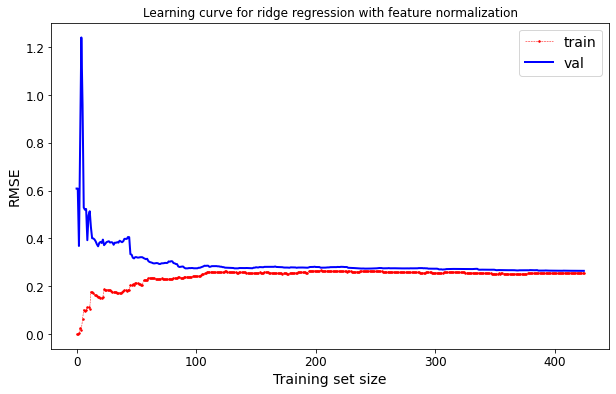

In [35]:
plot_learning_curves(linridge_norm, X_cancer, y_cancer,
                     title='Learning curve for ridge regression with feature normalization')


##### (4) Ridge regression with regularization parameter: alpha

In [59]:
print('Cancer dataset')
print('Ridge regression: effect of alpha regularization parameter\n')
for this_alpha in [0, 1, 10, 20, 50, 100, 1000]:
    linridge_a = Ridge(alpha=this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f} r-squared test: {:.2f}\n'
          .format(this_alpha, num_coeff_bigger, r2_train, r2_test))


Cancer dataset
Ridge regression: effect of alpha regularization parameter

Alpha = 0.00
num abs(coeff) > 1.0: 0, r-squared training: -18.25 r-squared test: -18.21

Alpha = 1.00
num abs(coeff) > 1.0: 0, r-squared training: -18.25 r-squared test: -18.21

Alpha = 10.00
num abs(coeff) > 1.0: 0, r-squared training: -18.25 r-squared test: -18.21

Alpha = 20.00
num abs(coeff) > 1.0: 0, r-squared training: -18.25 r-squared test: -18.21

Alpha = 50.00
num abs(coeff) > 1.0: 0, r-squared training: -18.25 r-squared test: -18.21

Alpha = 100.00
num abs(coeff) > 1.0: 0, r-squared training: -18.25 r-squared test: -18.21

Alpha = 1000.00
num abs(coeff) > 1.0: 0, r-squared training: -18.25 r-squared test: -18.21



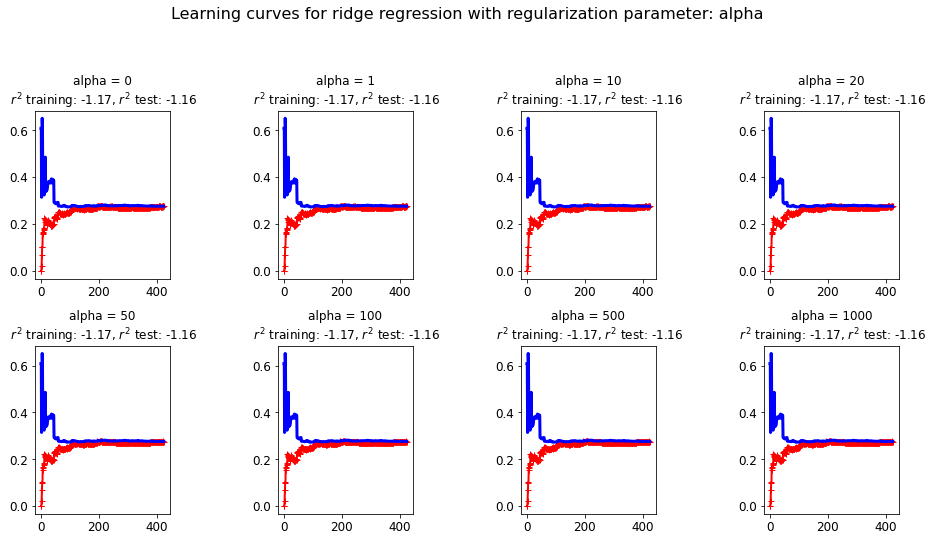

In [68]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

i = 0
for alpha in [0, 1, 10, 20, 50, 100, 500, 1000]:
    idx = (int(i / 4), i % 4)
    linridge_a = Ridge(alpha=this_alpha).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)
    y_predict = linridge_a.predict(X_cancer)

    train_errors, val_errors = [], []

    for m in range(1, len(X_train)):
        linridge_a.fit(X_train[:m], y_train[:m])
        y_train_predict = linridge_a.predict(X_train[:m])
        y_val_predict = linridge_a.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_test, y_val_predict))

    axs[idx].plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    axs[idx].plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    axs[idx].set_title('alpha = {}\n $r^2$ training: {:.2f}, $r^2$ test: {:.2f}'.format(
        alpha, r2_train, r2_test))

    i += 1
fig.suptitle(
    'Learning curves for ridge regression with regularization parameter: alpha', fontsize=16)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.8,
                    wspace=0.8,
                    hspace=0.4)
plt.show()


##### (5) Lasso regression

In [37]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer,
                                                    random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=2.0, max_iter=100000).fit(X_train_scaled, y_train)

print('Cancer dataset')

print('R-squared score (training): {:.3f}'
      .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
      .format(linlasso.score(X_test_scaled, y_test)))

# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(
    np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

print('lasso regression linear model intercept: {}'.format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'.format(linlasso.coef_))

print('Non-zero features: {}'.format(np.sum(linlasso.coef_ != 0)))

print('Features with non-zero weight (sorted by absolute magnitude):')
for e in sorted(list(zip(list(X_cancer), linlasso.coef_)),
                key=lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))


Cancer dataset
R-squared score (training): 0.000
R-squared score (test): -0.000

RMSE: 0.251
lasso regression linear model intercept: 0.6267605633802817
lasso regression linear model coeff:
[-0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0. -0. -0.  0. -0. -0. -0.
  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
Non-zero features: 0
Features with non-zero weight (sorted by absolute magnitude):


/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


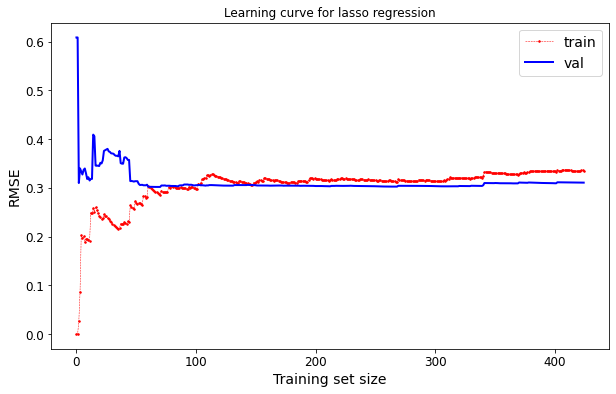

In [38]:
plot_learning_curves(linlasso, X_cancer, y_cancer,
                     title='Learning curve for lasso regression')


##### (6) Lasso regression with regularization parameter: alpha

In [49]:
print('Cancer dataset')
print('Lasso regression: effect of alpha regularization\n\
parameter on number of features kept in final model\n')

for alpha in [0.5, 1, 2, 3, 5, 10, 20, 50]:
    linlasso_a = Lasso(alpha, max_iter=10000).fit(X_train_scaled, y_train)
    r2_train = linlasso_a.score(X_train_scaled, y_train)
    r2_test = linlasso_a.score(X_test_scaled, y_test)
    y_predict = linlasso_a.predict(X_cancer)
    print('Alpha = {:.2f}\nFeatures kept: {}, r-squared training: {:.2f}, \
r-squared test: {:.2f}\n'
          .format(alpha, np.sum(linlasso.coef_ != 0), r2_train, r2_test))
    


Cancer dataset
Lasso regression: effect of alpha regularization
parameter on number of features kept in final model

Alpha = 0.50
Features kept: 1, r-squared training: 0.00, r-squared test: -0.00

Alpha = 1.00
Features kept: 1, r-squared training: 0.00, r-squared test: -0.00

Alpha = 2.00
Features kept: 1, r-squared training: 0.00, r-squared test: -0.00

Alpha = 3.00
Features kept: 1, r-squared training: 0.00, r-squared test: -0.00

Alpha = 5.00
Features kept: 1, r-squared training: 0.00, r-squared test: -0.00

Alpha = 10.00
Features kept: 1, r-squared training: 0.00, r-squared test: -0.00

Alpha = 20.00
Features kept: 1, r-squared training: 0.00, r-squared test: -0.00

Alpha = 50.00
Features kept: 1, r-squared training: 0.00, r-squared test: -0.00



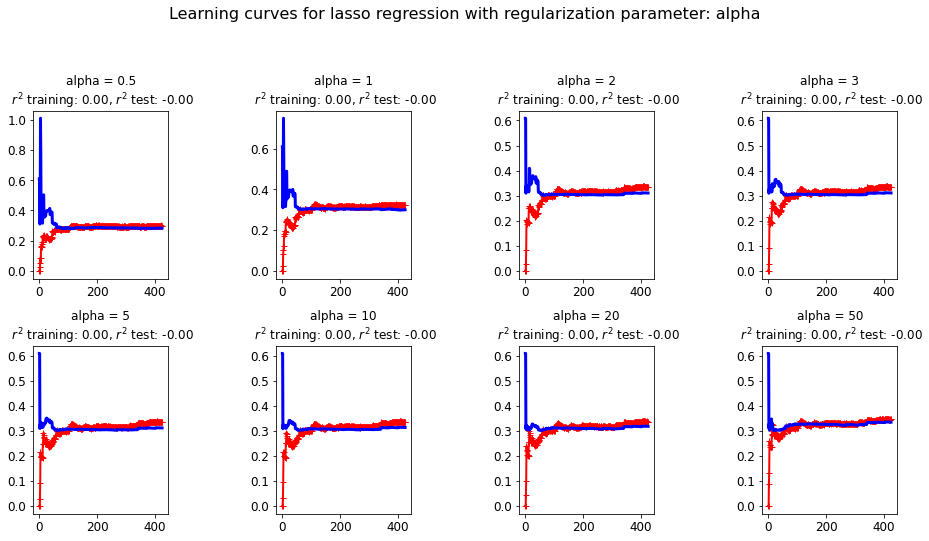

In [69]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

i = 0
for alpha in [0.5, 1, 2, 3, 5, 10, 20, 50]:
    idx = (int(i / 4), i % 4)
    linlasso_a = Lasso(alpha, max_iter=10000).fit(X_train_scaled, y_train)
    r2_train = linlasso_a.score(X_train_scaled, y_train)
    r2_test = linlasso_a.score(X_test_scaled, y_test)
    y_predict = linlasso_a.predict(X_cancer)

    train_errors, val_errors = [], []

    for m in range(1, len(X_train)):
        linlasso_a.fit(X_train[:m], y_train[:m])
        y_train_predict = linlasso_a.predict(X_train[:m])
        y_val_predict = linlasso_a.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_test, y_val_predict))

    axs[idx].plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    axs[idx].plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    axs[idx].set_title('alpha = {}\n $r^2$ training: {:.2f}, $r^2$ test: {:.2f}'.format(
        alpha, r2_train, r2_test))

    i += 1
fig.suptitle('Learning curves for lasso regression with regularization parameter: alpha', fontsize = 16)


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.8,
                    wspace=0.8,
                    hspace=0.4)
plt.show()


## Part 2

- Submit your summary to Canvas
- Provide a link to your Git repo of the assignment.